# Regularized logistic regression

Data: <br/>
features--two tests scores<br/>
response--whether be accepted

In [1]:
#输出多个output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

### 数据预处理

In [3]:
data = pd.read_table("data2.txt", header=None, sep=",", names=["Test1","Test2","Accepted"])
data.head()

,Test1,Test2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
Test1       118 non-null float64
Test2       118 non-null float64
Accepted    118 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.9 KB


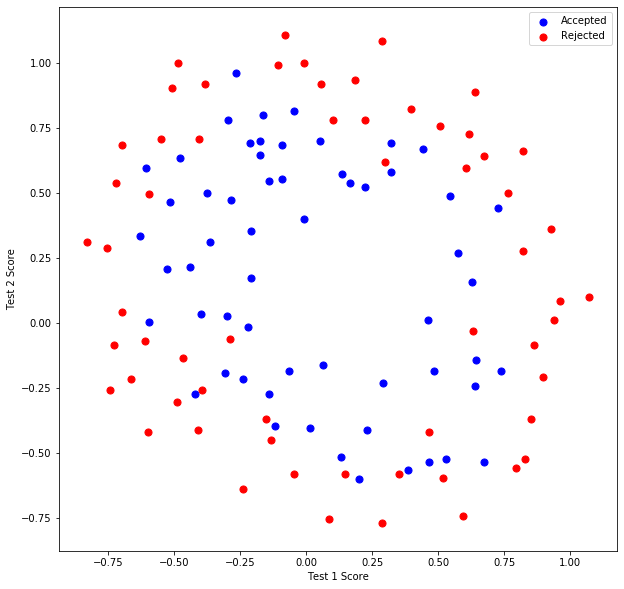

In [5]:
def plot_data():
    positive = data[data.Accepted.isin([1])]
    negative = data[data.Accepted.isin([0])]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(positive.Test1,positive.Test2,s=50,c="b",label="Accepted")
    ax.scatter(negative.Test1,negative.Test2,s=50,c="r",label="Rejected")
    ax.legend()
    ax.set_xlabel("Test 1 Score")
    ax.set_ylabel("Test 2 Score")
plot_data()

从图中我们可以发现，线性的boundary是无法分开两类的，我们将采用 yita = 多项式 <br/>
所以我们需要更多的特征（在本次回归中考虑6次多项式）

### Feature mapping

我们将X1和X2映射到所有的X1和X2的多项式上，直到6次幂

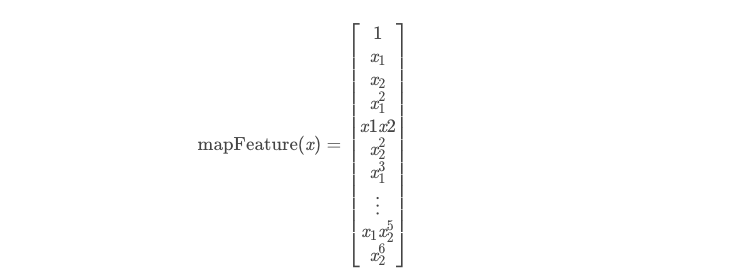

In [6]:
def feature_mapping(x, y, power, as_ndarray=False):

    data = {"f{}{}".format(i - p, p): np.power(x, i - p) * np.power(y, p)
                for i in np.arange(power + 1)
                for p in np.arange(i + 1)
            }

    if as_ndarray:
        return pd.DataFrame(data).as_matrix()
    else:
        return pd.DataFrame(data)

In [7]:
x1 = np.array(data.Test1)
x2 = np.array(data.Test2)

In [8]:
data2 = feature_mapping(x1,x2,power=6)
data2.head()

,f00,f10,f01,f20,f11,f02,f30,f21,f12,f03,...,f23,f14,f05,f60,f51,f42,f33,f24,f15,f06
0,1.0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1.0,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1.0,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1.0,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1.0,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


f10 --> x1<br/>f30 --> x1^3<br/>f51 --> x1^5 * x2<br/>f42 --> x1^4 * x2^2

### Sigmoid function

In [9]:
def sigmoid(z):
    h = 1 / (1+np.exp(-z))
    return h

### 变量初始化

In [10]:
cols = data2.shape[1]
X = data2.iloc[:,0:cols]
y = data.Accepted
# convert to numpy arrays and initalize the parameter array theta
X = np.array(X.values)
y = np.array(y)
theta = np.zeros(data2.shape[1])

In [11]:
X.shape,y.shape,theta.shape

((118, 28), (118,), (28,))

### Cost function

In [12]:
def cost(theta, X, y, lamda):
    first = (-y) * np.log(sigmoid(np.dot(X,theta)))#   * 表示array对应元素相乘
    second = (1 - y)*np.log(1 - sigmoid(np.dot(X,theta)))
    part1 = np.mean(first - second)
    part2 = (lamda/(2*len(X)))*(theta[1:]@theta[1:])#一维array内积
    return part1+part2

In [13]:
cost(theta,X,y,1)

0.6931471805599454

### Regularized gradient

In [14]:
def gradient(theta,X,y,lamda):
    grad = (X.T @ (sigmoid(np.dot(X,theta))-y))/len(X)#   @ 表示array的矩阵乘法和np.dot()是一样的
    reg = (lamda/len(X))*theta
    reg[0] = 0
    return grad + reg

In [15]:
gradient(theta,X,y,1)

array([8.47457627e-03, 1.87880932e-02, 7.77711864e-05, 5.03446395e-02,
       1.15013308e-02, 3.76648474e-02, 1.83559872e-02, 7.32393391e-03,
       8.19244468e-03, 2.34764889e-02, 3.93486234e-02, 2.23923907e-03,
       1.28600503e-02, 3.09593720e-03, 3.93028171e-02, 1.99707467e-02,
       4.32983232e-03, 3.38643902e-03, 5.83822078e-03, 4.47629067e-03,
       3.10079849e-02, 3.10312442e-02, 1.09740238e-03, 6.31570797e-03,
       4.08503006e-04, 7.26504316e-03, 1.37646175e-03, 3.87936363e-02])

### Optimization Algorithm

In [16]:
import scipy.optimize as opt

In [17]:
result = opt.fmin_tnc(func=cost,x0=theta,fprime=gradient, args=(X, y, 2))
result

(array([ 0.90267454,  0.33721089,  0.76006405, -1.39757946, -0.51417075,
        -0.91389986,  0.01516213, -0.21926017, -0.22677643, -0.16219637,
        -1.01270257, -0.04169398, -0.39984069, -0.14458017, -0.82296284,
        -0.20346048, -0.13186937, -0.04837714, -0.17183934, -0.17077936,
        -0.38820995, -0.72773035,  0.00607685, -0.19391899,  0.00314606,
        -0.21203169, -0.06947222, -0.69320885]), 25, 1)

### Evaluating logistic regression

In [18]:
def predict(theta, X):
    P = sigmoid(np.dot(X,theta))
    return [1 if x>=0.5 else 0 for x in P]

In [19]:
final_theta = result[0]
predictions = predict(final_theta, X)
correct = [1 if a==b else 0 for (a, b) in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
accuracy

0.8305084745762712

### Decision boundary

(-0.8, 1.2)

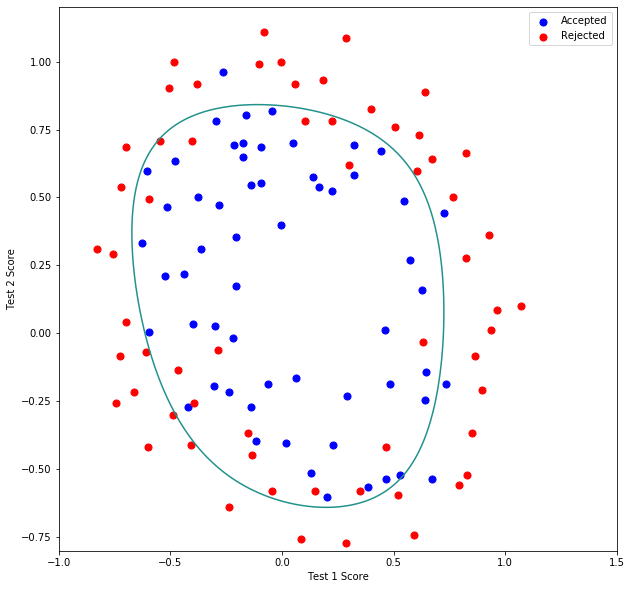

In [21]:
x = np.linspace(-1, 1.5, 250)
xx, yy = np.meshgrid(x, x)

z = feature_mapping(xx.ravel(), yy.ravel(), 6)
z = np.array(z.values)
z = z @ final_theta
z = z.reshape(xx.shape)

plot_data()
plt.contour(xx, yy, z, 0)
plt.ylim(-.8, 1.2)


Note: this is a good decision boundary<br/>
Then try lamda=0.01 which indicates overfit<br/>
And lamda=10 which indicates underfit